In [ ]:
# Install the required libraries
#SAM
#! pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
#! pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
#! pip install datasets
#! pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#! pip install patchify
#! pip install matplotlib
#! pip install tifffile
#! pip install scipy
#! pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm

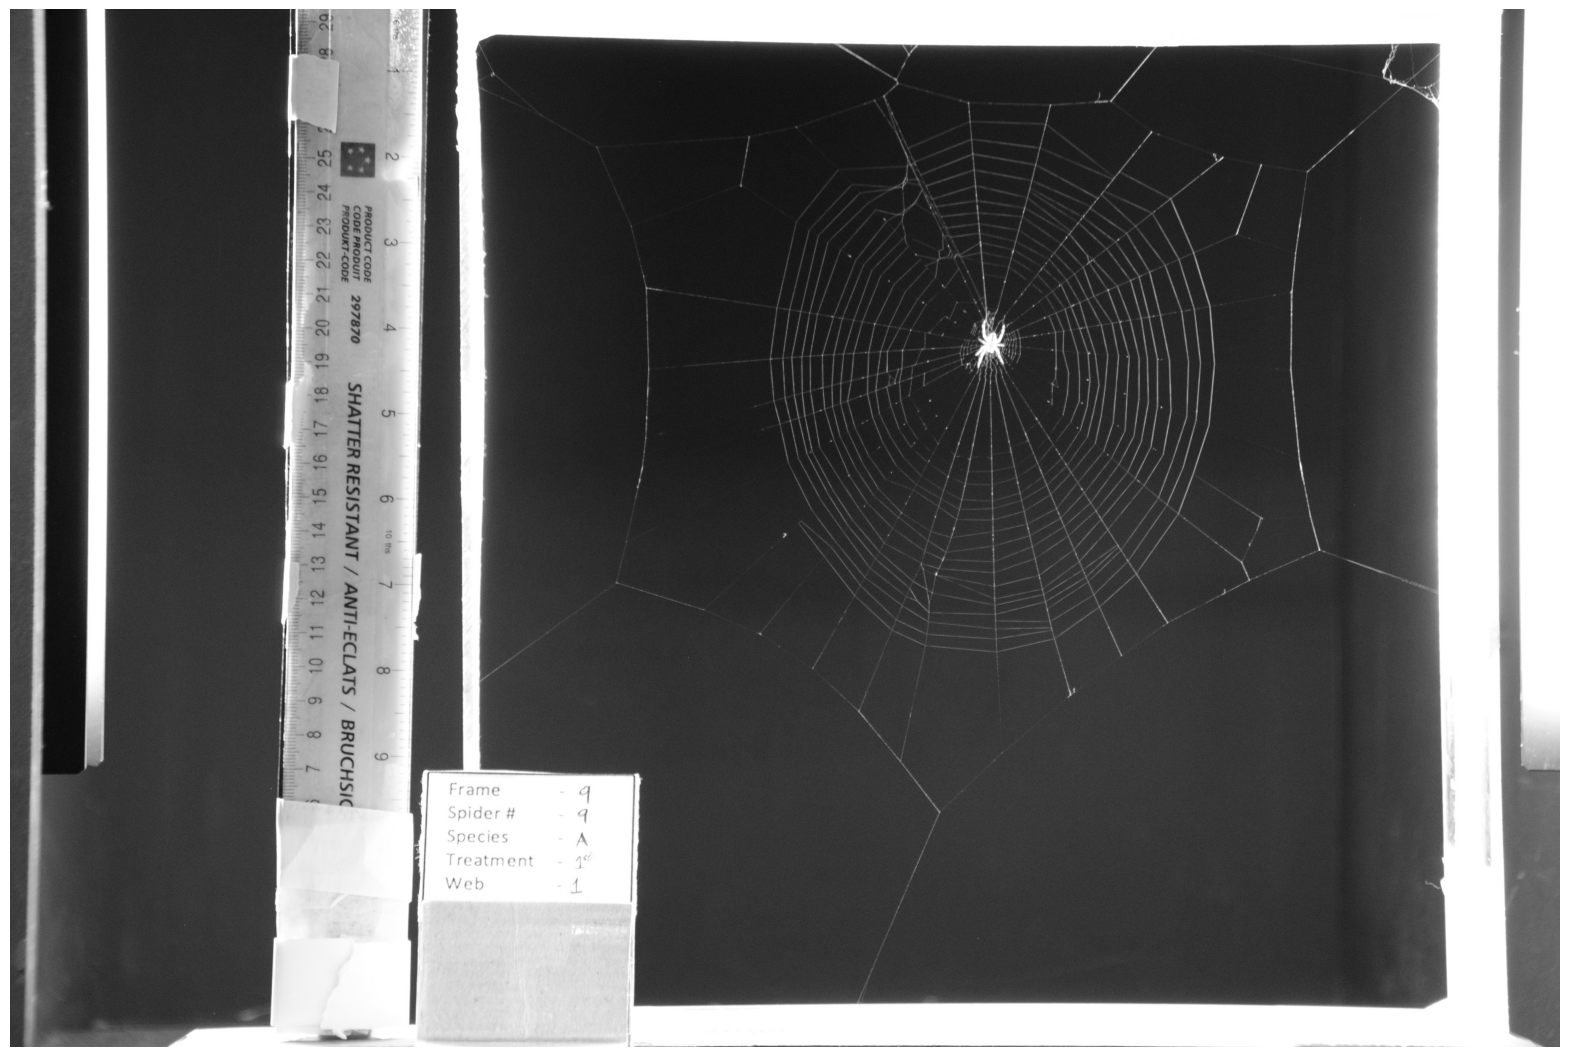

In [3]:
image = cv2.imread(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\9 - 1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
from huggingface_hub import hf_hub_download

# Download the SAM vit_h checkpoint
checkpoint_path = hf_hub_download(
    repo_id="HCMUE-Research/SAM-vit-h",       # You can also try "facebook/sam-vit-h" if available
    filename="sam_vit_h_4b8939.pth"
)

# Use it with SAM
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint=checkpoint_path)

c:\Users\adamain\.conda\envs\imgid\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

device = "cpu"

sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [6]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

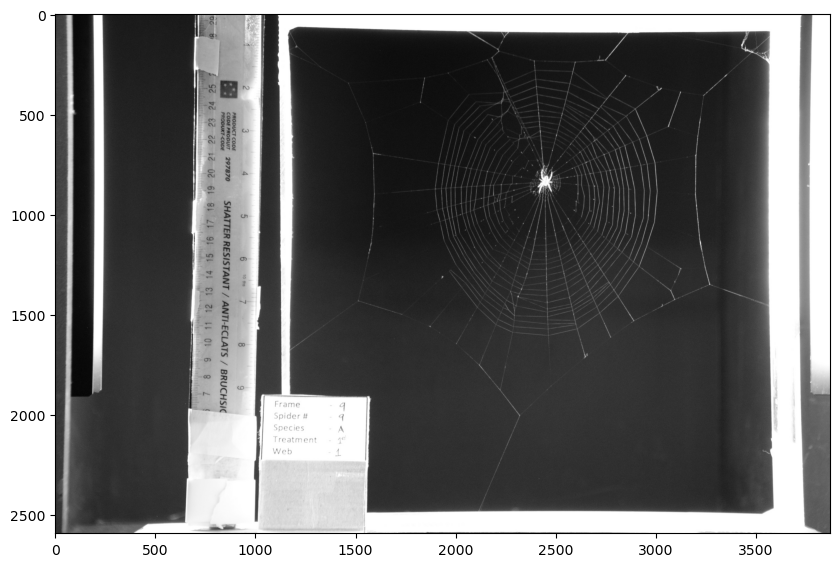

In [7]:
pointImage = cv2.imread(r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment\9 - 1.jpg")
pointImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(pointImage, cmap='gray')
plt.axis('on')
plt.show()

In [8]:
predictor = SamPredictor(sam)

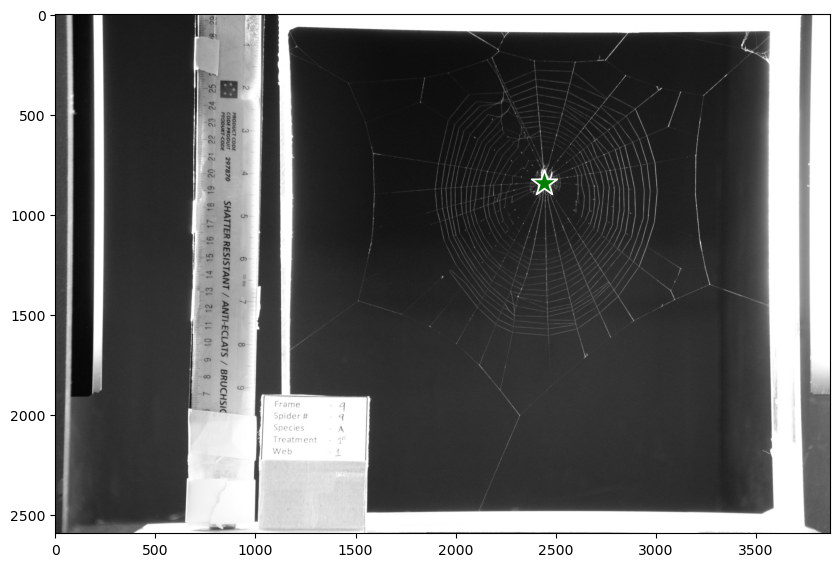

In [9]:
input_point = np.array([[2440, 840]]) #Location of spider in first image in folder
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(pointImage, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [10]:
_, thresh = cv2.threshold(pointImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


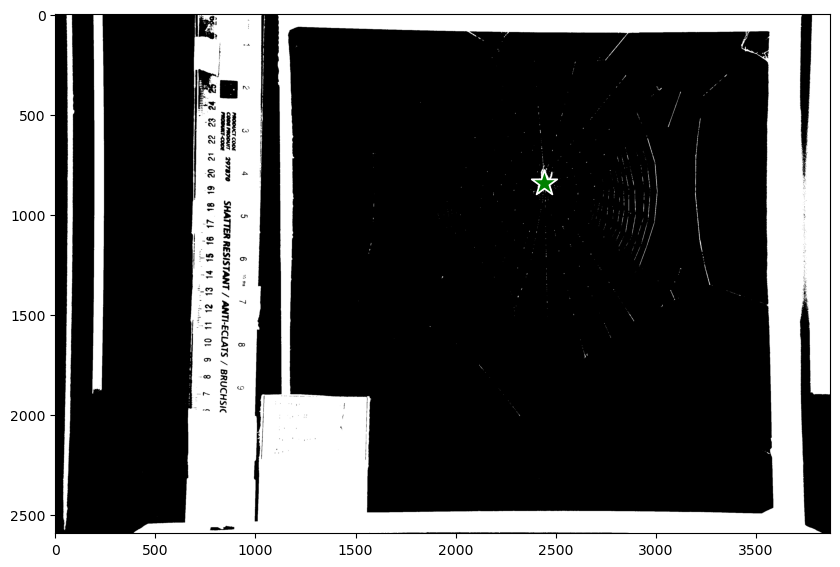

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap='gray')
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [12]:
rgb_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
predictor.set_image(rgb_thresh)

In [13]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

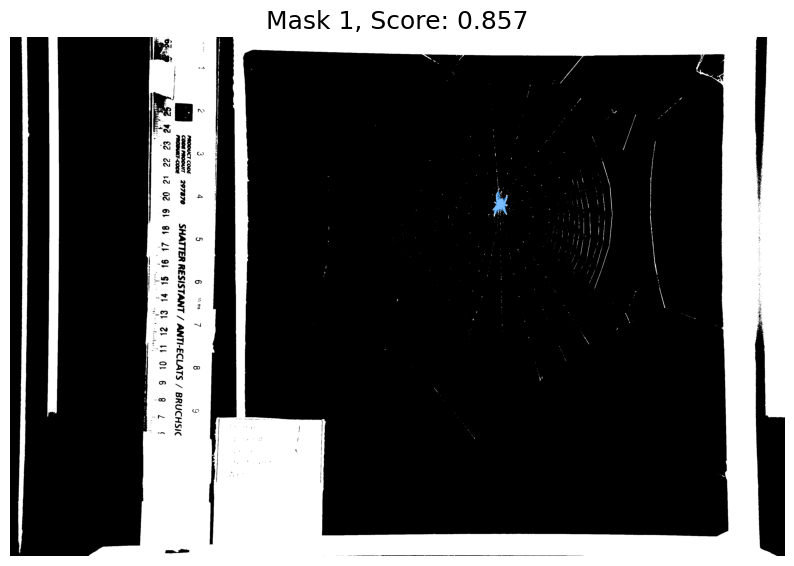

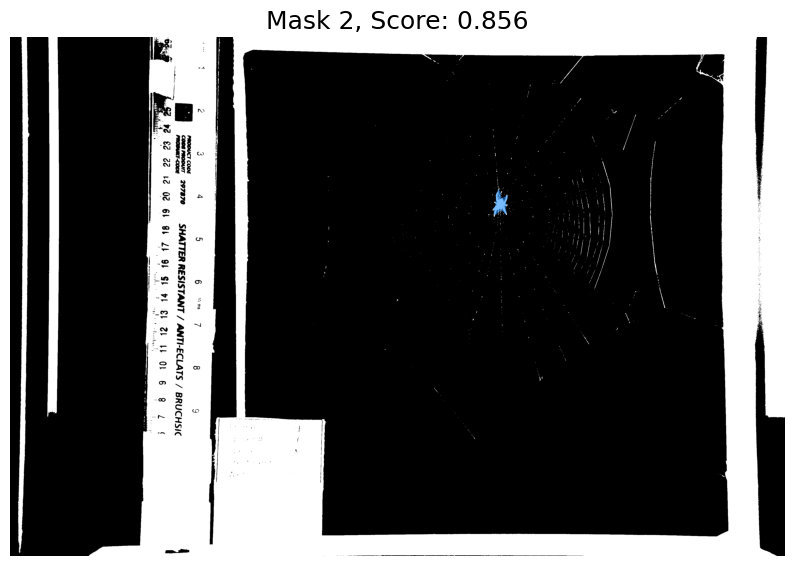

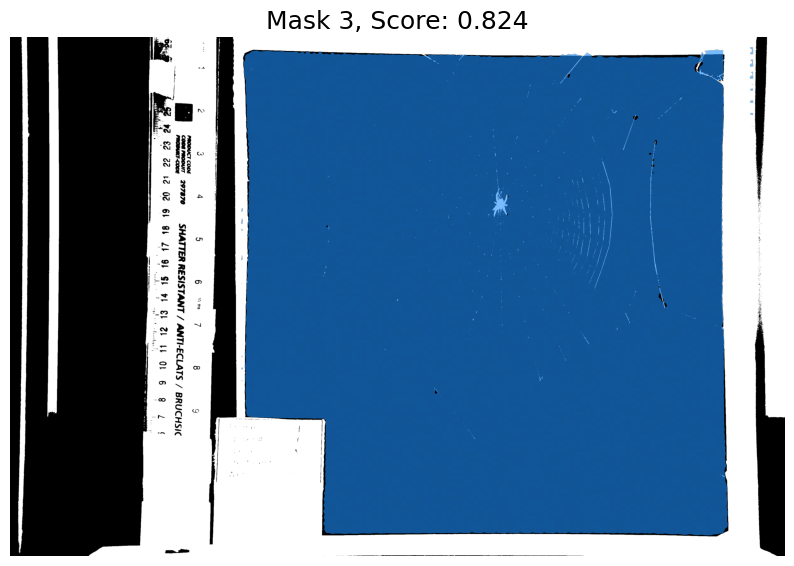

In [14]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(rgb_thresh)
    show_mask(mask, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

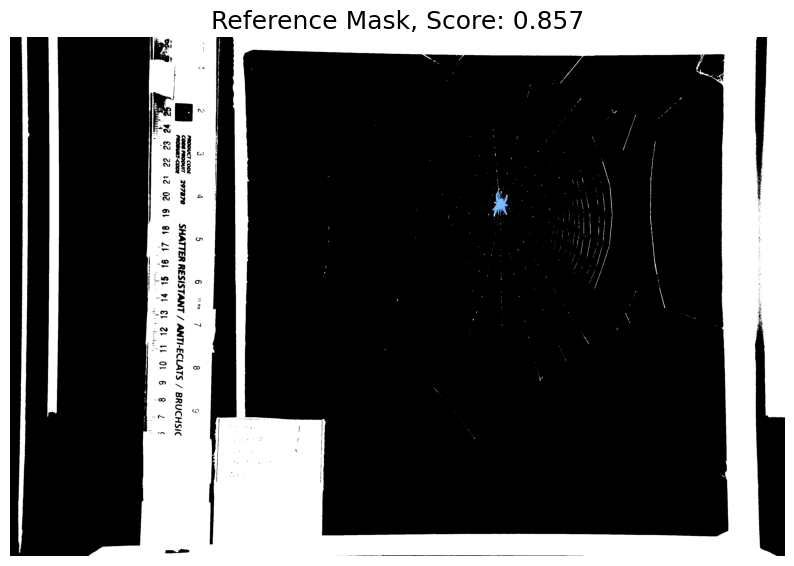

In [15]:
reference = masks[0]
referenceScore = scores[0]
plt.figure(figsize=(10,10))
plt.imshow(rgb_thresh)
show_mask(reference, plt.gca())
plt.title(f"Reference Mask, Score: {referenceScore:.3f}", fontsize=18)
plt.axis('off')
plt.show()  

In [16]:
def crop_to_mask_circle(image, mask, padding=10):
    """
    Crop the image to the smallest enclosing circle around the non-zero region in the mask.

    Parameters:
        image (np.ndarray): Original image (H, W, C)
        mask (np.ndarray): Binary mask (H, W) where non-zero values define the region of interest
        padding (int): Optional padding around the circle (in pixels)

    Returns:
        cropped_image (np.ndarray): Cropped image around the circular region
    """
    # Ensure mask is binary
    mask = (mask > 0).astype(np.uint8)

    # Get coordinates of the non-zero mask area
    points = cv2.findNonZero(mask)
    if points is None:
        return None  # or raise an exception

    # Find the smallest enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(points)

    # Add padding
    x, y, radius = int(x), int(y), int(radius + padding)

    # Compute square bounding box
    x1 = max(x - radius, 0)
    y1 = max(y - radius, 0)
    x2 = min(x + radius, image.shape[1])
    y2 = min(y + radius, image.shape[0])

    # Crop the image
    cropped_image = image[y1:y2, x1:x2]
    cropped_mask = mask[y1:y2, x1:x2]

    return cropped_image, cropped_mask


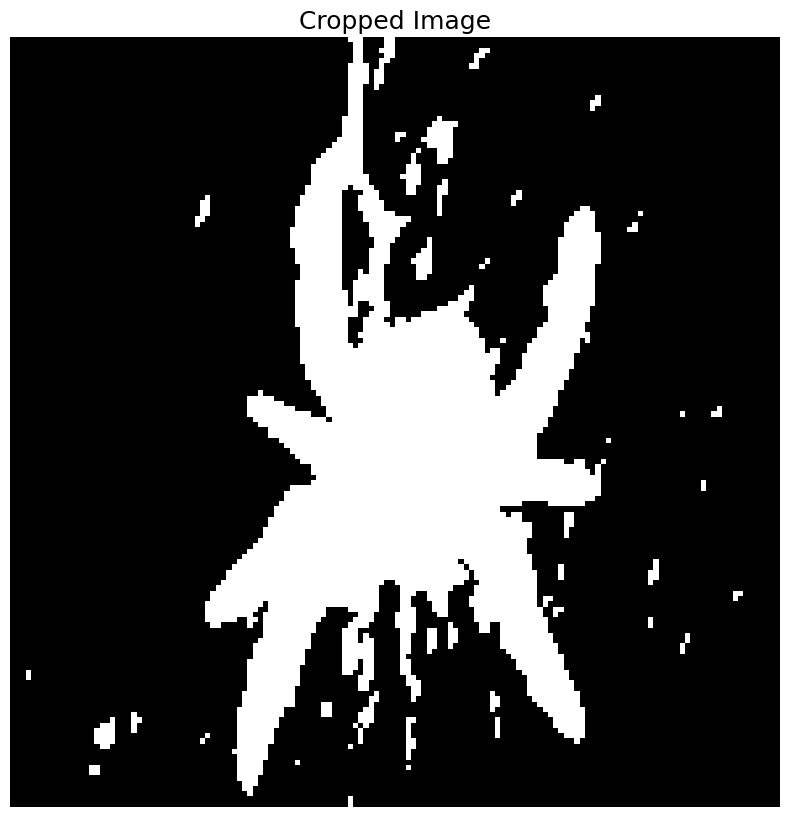

In [17]:
crop, cropMask = crop_to_mask_circle(rgb_thresh, reference)

plt.figure(figsize=(10,10))
plt.imshow(crop)
plt.title(f"Cropped Image", fontsize=18)
plt.axis('off')
plt.show()  

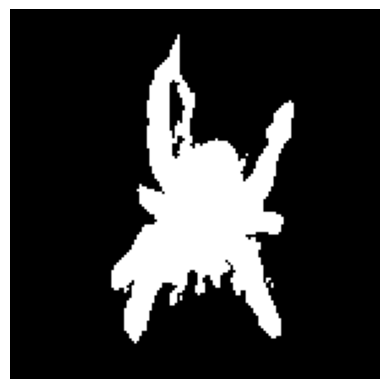

In [18]:
reference = reference.astype(np.uint8) * 255
if reference.shape != crop.shape:
    reference = cv2.resize(reference, (crop.shape[1], crop.shape[0]))


spider_only = cv2.bitwise_and(crop, crop, mask=cropMask)
plt.imshow(spider_only, cmap='gray'), plt.axis("off")
plt.show()

In [19]:
# Ensure grayscale
if len(spider_only.shape) == 3:
    spider_only = cv2.cvtColor(spider_only, cv2.COLOR_BGR2GRAY)

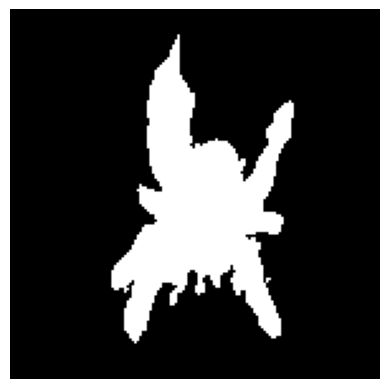

In [20]:
contours, _ = cv2.findContours(spider_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

edited = np.zeros_like(spider_only)
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = cv2.contourArea(cnt)
    aspect_ratio = float(w) / h if h != 0 else 0

    if area > 500 and aspect_ratio < 4:  # keep only “chunkier” shapes
        cv2.drawContours(edited, [cnt], -1, 255, thickness=cv2.FILLED)
plt.imshow(edited, cmap='gray'), plt.axis("off")
plt.show()

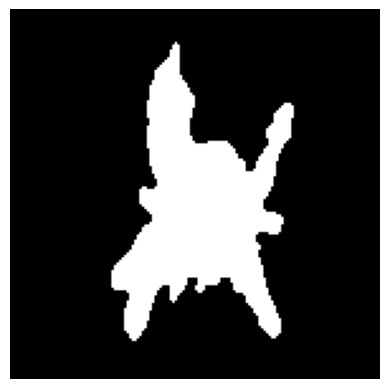

In [51]:
# Smooth the binary spider mask before analysis
edited = cv2.GaussianBlur(edited, (5, 5), 0)

# Optional: Morphological closing to fill small holes in legs/body
kernel = np.ones((3, 3), np.uint8)
edited = cv2.morphologyEx(edited, cv2.MORPH_CLOSE, kernel)

# Re-binarize after smoothing (ensures pixel values are 0 or 255 again)
_, edited = cv2.threshold(edited, 127, 255, cv2.THRESH_BINARY)
plt.imshow(edited, cmap = 'gray'), plt.axis("off")
plt.show()

In [269]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# def count_spider_legs(image, show_image=False):
#     # Find contours and select the largest one (spider body + legs)
#     contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     if not contours:
#         return 0  # No contour found

#     main_contour = max(contours, key=cv2.contourArea)

#     # Get centroid of the contour
#     M = cv2.moments(main_contour)
#     if M["m00"] == 0:
#         return 0  # Avoid divide-by-zero
#     cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
#     center = np.array([cx, cy])

#     # Convert contour to polar coordinates
#     angles = []
#     radii = []
#     points = []

#     for pt in main_contour:
#         x, y = pt[0]
#         vec = np.array([x, y]) - center
#         angle = np.arctan2(vec[1], vec[0])
#         radius = np.linalg.norm(vec)
#         angles.append(angle)
#         radii.append(radius)
#         points.append((x, y))

#     angles = np.array(angles)
#     radii = np.array(radii)
#     points = np.array(points)

#     # Sort points by angle
#     sort_idx = np.argsort(angles)
#     angles = angles[sort_idx]
#     radii = radii[sort_idx]
#     points = points[sort_idx]

#     # Find radius peaks (potential leg tips)
#     peaks, _ = find_peaks(radii, distance=3, prominence=2)
#     peak_angles = angles[peaks]
#     peak_radii = radii[peaks]
#     peak_points = points[peaks]

#     # Angular suppression to avoid counting the same leg multiple times
#     def angular_suppression(peak_angles, peak_radii, peak_points, min_angle_rad):
#         selected = []
#         for angle_i, radius_i, point_i in zip(peak_angles, peak_radii, peak_points):
#             keep = True
#             for angle_j, radius_j, point_j in zip(*zip(*selected)) if selected else []:
#                 angle_diff = np.abs(angle_i - angle_j)
#                 angle_diff = min(angle_diff, 2*np.pi - angle_diff)
#                 if angle_diff < min_angle_rad:
#                     if radius_i > radius_j:
#                         selected.remove((angle_j, radius_j, point_j))
#                     else:
#                         keep = False
#                     break
#             if keep:
#                 selected.append((angle_i, radius_i, point_i))
#         return selected

#     # Start with 20° minimum angle
#     min_angle_deg = 20
#     selected = angular_suppression(peak_angles, peak_radii, peak_points, np.deg2rad(min_angle_deg))

#     # If too many legs detected, suppress more aggressively
#     while len(selected) > 8 and min_angle_deg < 60:
#         min_angle_deg += 5
#         selected = angular_suppression(peak_angles, peak_radii, peak_points, np.deg2rad(min_angle_deg))

#     # Show image with annotations if requested
#     if show_image:
#         result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
#         cv2.circle(result, tuple(center), 5, (0, 255, 0), -1)  # Center in green
#         for _, _, pt in selected:
#             cv2.circle(result, tuple(pt), 3, (0, 255, 255), -1)  # Tips in cyan
#         plt.imshow(result, cmap = 'gray'), plt.axis("off")
#         plt.title(f"Detected legs: {len(selected)}")
#         plt.show()

#     return len(selected)

def count_spider_legs(image, show_image=False, exclude_centerband_px=5):
    # Find contours and select the largest one (spider body + legs)
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return 0

    main_contour = max(contours, key=cv2.contourArea)

    # Get centroid of the contour
    M = cv2.moments(main_contour)
    if M["m00"] == 0:
        return 0
    cx, cy = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])
    center = np.array([cx, cy])

    # Convert contour to polar coordinates
    angles = []
    radii = []
    points = []

    for pt in main_contour:
        x, y = pt[0]
        vec = np.array([x, y]) - center
        angle = np.arctan2(vec[1], vec[0])
        radius = np.linalg.norm(vec)
        angles.append(angle)
        radii.append(radius)
        points.append((x, y))

    angles = np.array(angles)
    radii = np.array(radii)
    points = np.array(points)

    # Sort points by angle
    sort_idx = np.argsort(angles)
    angles = angles[sort_idx]
    radii = radii[sort_idx]
    points = points[sort_idx]

    # Find radius peaks
    peaks, _ = find_peaks(radii, distance=3, prominence=2)
    peak_angles = angles[peaks]
    peak_radii = radii[peaks]
    peak_points = points[peaks]

    # Exclude points near vertical centerline
    filtered_angles = []
    filtered_radii = []
    filtered_points = []
    for angle, radius, pt in zip(peak_angles, peak_radii, peak_points):
        if abs(pt[0] - cx) > exclude_centerband_px:
            filtered_angles.append(angle)
            filtered_radii.append(radius)
            filtered_points.append(pt)

    # Angular suppression to avoid counting the same leg multiple times
    def angular_suppression(peak_angles, peak_radii, peak_points, min_angle_rad):
        selected = []
        for angle_i, radius_i, point_i in zip(peak_angles, peak_radii, peak_points):
            keep = True
            for angle_j, radius_j, point_j in zip(*zip(*selected)) if selected else []:
                angle_diff = np.abs(angle_i - angle_j)
                angle_diff = min(angle_diff, 2*np.pi - angle_diff)
                if angle_diff < min_angle_rad:
                    if radius_i > radius_j:
                        selected.remove((angle_j, radius_j, point_j))
                    else:
                        keep = False
                    break
            if keep:
                selected.append((angle_i, radius_i, point_i))
        return selected

    # Start with 20° and increase if needed
    min_angle_deg = 20
    selected = angular_suppression(filtered_angles, filtered_radii, filtered_points, np.deg2rad(min_angle_deg))
    while len(selected) > 7 and min_angle_deg < 60:
        min_angle_deg += 2
        selected = angular_suppression(filtered_angles, filtered_radii, filtered_points, np.deg2rad(min_angle_deg))

    # Visualization
    if show_image:
        result = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.circle(result, (cx, cy), 5, (0, 255, 0), -1)  # Center dot
        for _, _, pt in selected:
            cv2.circle(result, tuple(pt), 3, (0, 255, 255), -1)  # Leg tips
        plt.imshow(result), plt.axis("off")
        plt.title(f"Detected legs: {len(selected)}")
        plt.show()

    return len(selected)



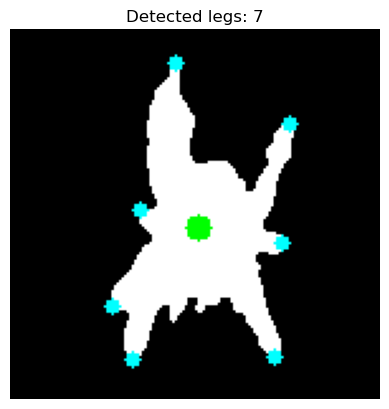

7


In [270]:
print(count_spider_legs(image = edited, show_image = True))

In [ ]:
# import numpy as np
# import cv2
# import os
# from segment_anything import SamPredictor
# from openvino.runtime import Core
# from tqdm import tqdm

# def generate_spider_masks(ref_image_path, ref_point, image_paths, predictor: SamPredictor):
#     """
#     Generates masks in new images using a SAM predictor based on the reference point's embedding.

#     Parameters:
#     - ref_image_path: str, path to the reference image
#     - ref_point: tuple of int (x, y), point on spider in the reference image
#     - image_paths: list of str, paths to all target images
#     - predictor: initialized SamPredictor

#     Returns:
#     - List of (image_path, mask) tuples
#     """

#     # Step 1: Load and embed reference image
#     ref_image = cv2.imread(ref_image_path)
#     ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
#     predictor.set_image(ref_image)

#     # Get full image embedding
#     ref_embedding = predictor.get_image_embedding().cpu().numpy()[0]  # shape [256, 64, 64]

#     # Map point to embedding resolution
#     h, w = ref_image.shape[:2]
#     embed_h, embed_w = ref_embedding.shape[1:]
#     embed_x = int(ref_point[0] * embed_w / w)
#     embed_y = int(ref_point[1] * embed_h / h)

#     # Extract reference embedding vector at the point
#     spider_vec = ref_embedding[:, embed_y, embed_x]  # shape [256]
#     spider_vec /= np.linalg.norm(spider_vec)

#     results = []

#     # Step 2: Iterate through dataset
#     for img_path in tqdm(image_paths, desc="Generating masks"):
#         img = cv2.imread(img_path)
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         rgb_thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
#         predictor.set_image(rgb_thresh)
#         emb = predictor.get_image_embedding().cpu().numpy()[0]

#         # Normalize embedding
#         emb_norm = emb / np.linalg.norm(emb, axis=0, keepdims=True)

#         # Cosine similarity with reference vector
#         similarity = np.tensordot(spider_vec, emb_norm, axes=(0, 0))  # shape [64, 64]
#         max_y, max_x = np.unravel_index(np.argmax(similarity), similarity.shape)

#         # Map back to original image coordinates
#         H, W = img.shape[:2]
#         point_x = int(max_x * W / embed_w)
#         point_y = int(max_y * H / embed_h)

#         # Step 3: Predict mask
#         input_point = np.array([[point_x, point_y]])
#         input_label = np.array([1])
#         masks, scores, _ = predictor.predict(
#             point_coords=input_point,
#             point_labels=input_label,
#             multimask_output=True  # get multiple masks to choose from
#         )

#         # Pick the smallest mask by area
#         best_idx = np.argmin([np.sum(mask) for mask in masks])
#         results.append((img_path, masks[best_idx]))

#     return results



In [311]:
# import cv2
# import numpy as np
# import torch
# from sam2.sam2_image_predictor import SAM2ImagePredictor 

# class SpiderSegmenterSAM2:
#     def __init__(self, sam_checkpoint: str, device: str = "cpu"):
#         print("[Init] Loading SAM2 model...")
#         self.device = device
#         self.predictor = SAM2ImagePredictor.from_pretrained(sam_checkpoint, device=device)
#         self.ref_embedding = None

#     def preprocess_for_embedding(self, image_bgr):
#         print("[Preprocessing] Converting to grayscale and applying Otsu's threshold")
#         gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
#         _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#         return cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

#     def extract_mask_embedding(self, image_rgb, mask):
#         print("[Embedding] Setting image for predictor")
#         self.predictor.set_image(image_rgb)

#         print("[Embedding] Getting image embedding")
#         img_embedding = self.predictor.get_image_embedding()

#         if isinstance(img_embedding, tuple):
#             img_embedding = img_embedding[0]

#         # Convert tensor to numpy (assuming shape [1,C,H,W])
#         if hasattr(img_embedding, "shape") and len(img_embedding.shape) == 4:
#             img_embedding = img_embedding.squeeze(0).permute(1, 2, 0).cpu().numpy()
#         elif hasattr(img_embedding, "cpu"):
#             img_embedding = img_embedding.cpu().numpy()

#         H_feat, W_feat = img_embedding.shape[:2]

#         # Binarize and resize mask to embedding size
#         mask_bin = (mask > 0).astype(np.uint8)
#         mask_resized = cv2.resize(mask_bin, (W_feat, H_feat), interpolation=cv2.INTER_NEAREST)
#         mask_bool = mask_resized.astype(bool)

#         print(f"[Embedding] Mask resized shape: {mask_resized.shape}, nonzero pixels: {np.sum(mask_resized)}")

#         if np.sum(mask_bool) == 0:
#             print("[Embedding] Warning: Mask has zero area after resize.")
#             return None

#         masked_emb = img_embedding[mask_bool]
#         mean_emb = masked_emb.mean(axis=0)
#         print("[Embedding] Extracted mean embedding vector")
#         return mean_emb

#     def set_reference(self, ref_img_bgr, ref_mask):
#         print("[Reference] Preprocessing reference image")
#         ref_img_rgb = self.preprocess_for_embedding(ref_img_bgr)

#         print("[Reference] Extracting reference embedding")
#         emb = self.extract_mask_embedding(ref_img_rgb, ref_mask)
#         if emb is None:
#             raise ValueError("Reference embedding extraction failed — check your reference mask.")
#         self.ref_embedding = emb

#     def remove_large_components(self, mask, max_area):
#         """
#         Remove connected components from mask whose area > max_area.
#         Args:
#             mask: binary mask (bool or uint8)
#             max_area: maximum allowed connected component area (pixels)
#         Returns:
#             cleaned mask (same shape, bool)
#         """
#         mask_uint8 = mask.astype(np.uint8)
#         num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8)

#         cleaned_mask = np.zeros_like(mask_uint8)
#         for label in range(1, num_labels):  # skip background label 0
#             area = stats[label, cv2.CC_STAT_AREA]
#             if area <= max_area:
#                 cleaned_mask[labels == label] = 1

#         return cleaned_mask.astype(bool)

#     def largest_connected_component(self, mask):
#         mask_uint8 = mask.astype(np.uint8)
#         num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8)
#         if num_labels <= 1:
#             return mask  # no components found, return original

#         largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
#         return labels == largest_label

#     def generate_spider_mask(self, image_bgr):
#         if self.ref_embedding is None:
#             raise ValueError("Reference embedding not set. Call set_reference() first.")

#         print("[Generate] Preprocessing new image")
#         image_rgb = self.preprocess_for_embedding(image_bgr)

#         print("[Generate] Setting image for SAM2")
#         self.predictor.set_image(image_rgb)

#         print("[Generate] Predicting masks")
#         masks, scores, logits = self.predictor.predict(multimask_output=True)
#         print(f"[Generate] {len(masks)} masks returned by SAM2")

#         max_component_area = 135 * 165  # Max allowed connected component size (pixels)

#         best_mask = None
#         best_score = -1

#         for i, mask in enumerate(masks):
#             # Clean mask by removing large connected components
#             cleaned_mask = self.remove_large_components(mask, max_component_area)

#             if cleaned_mask.sum() == 0:
#                 print(f"[Generate] Mask {i} empty after cleaning, skipping.")
#                 continue

#             emb = self.extract_mask_embedding(image_rgb, cleaned_mask)
#             if emb is None:
#                 print(f"[Generate] Mask {i} embedding extraction failed, skipping.")
#                 continue

#             dot = np.dot(emb, self.ref_embedding)
#             norm_prod = np.linalg.norm(emb) * np.linalg.norm(self.ref_embedding)
#             if norm_prod == 0:
#                 print(f"[Generate] Mask {i} zero norm product, skipping.")
#                 continue
#             cos_sim = dot / norm_prod

#             print(f"[Generate] Mask {i} cosine similarity: {cos_sim:.4f}, area after cleaning: {cleaned_mask.sum()}")

#             if cos_sim > best_score:
#                 best_score = cos_sim
#                 best_mask = cleaned_mask

#         if best_mask is None:
#             raise RuntimeError("Failed to find a suitable spider mask.")

#         # Optional: Keep only largest connected component to clean residual noise
#         best_mask = self.largest_connected_component(best_mask)

#         print("[Generate] Best mask selected")

#         return best_mask.astype(bool)

import cv2
import numpy as np
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor 

class SpiderSegmenterSAM2:
    def __init__(self, sam_checkpoint: str, device: str = "cpu"):
        print("[Init] Loading SAM2 model...")
        self.device = device
        self.predictor = SAM2ImagePredictor.from_pretrained(sam_checkpoint, device=device)
        self.ref_embedding = None

    def preprocess_for_embedding(self, image_bgr):
        print("[Preprocessing] Converting to grayscale and applying Otsu's threshold")
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    def extract_mask_embedding(self, image_rgb, mask):
        print("[Embedding] Setting image for predictor")
        self.predictor.set_image(image_rgb)

        print("[Embedding] Getting image embedding")
        img_embedding = self.predictor.get_image_embedding()
        if isinstance(img_embedding, tuple):
            img_embedding = img_embedding[0]

        if hasattr(img_embedding, "shape") and len(img_embedding.shape) == 4:
            img_embedding = img_embedding.squeeze(0).permute(1, 2, 0).cpu().numpy()
        elif hasattr(img_embedding, "cpu"):
            img_embedding = img_embedding.cpu().numpy()

        H_feat, W_feat = img_embedding.shape[:2]

        mask_bin = (mask > 0).astype(np.uint8)
        mask_resized = cv2.resize(mask_bin, (W_feat, H_feat), interpolation=cv2.INTER_NEAREST)
        mask_bool = mask_resized.astype(bool)

        print(f"[Embedding] Mask resized shape: {mask_resized.shape}, nonzero pixels: {np.sum(mask_resized)}")

        if np.sum(mask_bool) == 0:
            print("[Embedding] Warning: Mask has zero area after resize.")
            return None

        masked_emb = img_embedding[mask_bool]
        mean_emb = masked_emb.mean(axis=0)
        print("[Embedding] Extracted mean embedding vector")
        return mean_emb

    def set_reference(self, ref_img_bgr, ref_mask):
        print("[Reference] Preprocessing reference image")
        ref_img_rgb = self.preprocess_for_embedding(ref_img_bgr)

        print("[Reference] Extracting reference embedding")
        emb = self.extract_mask_embedding(ref_img_rgb, ref_mask)
        if emb is None:
            raise ValueError("Reference embedding extraction failed — check your reference mask.")
        self.ref_embedding = emb

    def remove_large_components(self, mask, max_area):
        mask_uint8 = mask.astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8)

        cleaned_mask = np.zeros_like(mask_uint8)
        for label in range(1, num_labels):
            area = stats[label, cv2.CC_STAT_AREA]
            if area <= max_area:
                cleaned_mask[labels == label] = 1

        return cleaned_mask.astype(bool)

    def largest_connected_component(self, mask):
        mask_uint8 = mask.astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8)
        if num_labels <= 1:
            return mask
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        return labels == largest_label

    def is_rectangular(self, mask, aspect_thresh=0.15):
        """
        Reject masks that are overly rectangular (e.g. frames or text boxes).
        aspect_thresh = how close the contour is to a perfect rectangle (0 = perfect square/rectangle)
        """
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w == 0 or h == 0:
                continue
            aspect_ratio = min(w, h) / max(w, h)
            if aspect_ratio < aspect_thresh:
                return True  # too flat
            rect_area = w * h
            contour_area = cv2.contourArea(cnt)
            fill_ratio = contour_area / rect_area if rect_area != 0 else 0
            if fill_ratio > 0.9:
                return True  # very full rectangle
        return False

    def generate_spider_mask(self, image_bgr):
        if self.ref_embedding is None:
            raise ValueError("Reference embedding not set. Call set_reference() first.")

        print("[Generate] Preprocessing new image")
        image_rgb = self.preprocess_for_embedding(image_bgr)

        print("[Generate] Setting image for SAM2")
        self.predictor.set_image(image_rgb)

        print("[Generate] Predicting masks")
        masks, scores, logits = self.predictor.predict(multimask_output=True)
        print(f"[Generate] {len(masks)} masks returned by SAM2")

        max_component_area = 135 * 165
        best_mask = None
        best_score = -1

        def evaluate_masks(mask_list, allow_rectangles=False):
            nonlocal best_mask, best_score
            for i, mask in enumerate(mask_list):
                cleaned_mask = self.remove_large_components(mask, max_component_area)

                if cleaned_mask.sum() == 0:
                    print(f"[Generate] Mask {i} empty after cleaning, skipping.")
                    continue

                if not allow_rectangles and self.is_rectangular(cleaned_mask):
                    print(f"[Generate] Mask {i} rejected for rectangular geometry")
                    continue

                emb = self.extract_mask_embedding(image_rgb, cleaned_mask)
                if emb is None:
                    print(f"[Generate] Mask {i} embedding extraction failed, skipping.")
                    continue

                dot = np.dot(emb, self.ref_embedding)
                norm_prod = np.linalg.norm(emb) * np.linalg.norm(self.ref_embedding)
                if norm_prod == 0:
                    print(f"[Generate] Mask {i} zero norm product, skipping.")
                    continue

                cos_sim = dot / norm_prod
                print(f"[Generate] Mask {i} cosine similarity: {cos_sim:.4f}, area after cleaning: {cleaned_mask.sum()}")

                if cos_sim > best_score:
                    best_score = cos_sim
                    best_mask = cleaned_mask

        # Pass 1: strict filtering
        evaluate_masks(masks, allow_rectangles=False)

        # Fallback: if no mask selected, retry with relaxed filtering
        if best_mask is None:
            print("[Generate] No good mask found with strict filtering, retrying with relaxed criteria...")
            evaluate_masks(masks, allow_rectangles=True)

        if best_mask is None:
            raise RuntimeError("Failed to find a suitable spider mask even after relaxing criteria.")

        best_mask = self.largest_connected_component(best_mask)
        print("[Generate] Best mask selected (possibly fallback)")
        return best_mask.astype(bool)



In [ ]:
directory = r"C:\Files\Araneus diadematus\Missing leg study\Missing leg treatment"
image_paths = []
for filename in os.listdir(directory):
    if filename.lower().endswith(".jpg"):
        image_paths.append(os.path.join(directory, filename))
#We already have the mask for this one, it's the reference image/mask        
image_paths.remove('C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\9 - 1.jpg')
print(image_paths)


['C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 1.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 2.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - 3.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\19 - C.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - 1.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - 2.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - 3.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\25 - C.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\26 - 1.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\26 - 2.JPG', 'C:\\Files\\Araneus diadematus\\Missing leg study\\Missing leg treatment\\26 - 3.JPG', 'C:\\Files\\Araneus diadematus\\Missing le

In [314]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def show_mask_on_image(image_bgr, mask):
    # Convert BGR image (OpenCV) to RGB for matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    
    # Ensure mask is boolean
    if mask.dtype != bool:
        mask_display = mask.astype(bool)
    else:
        mask_display = mask
    
    # Overlay the mask with transparency
    plt.imshow(mask_display, cmap='gray', alpha=0.5)  # alpha controls transparency
    
    plt.axis('off')
    plt.title("Predicted Spider Mask Overlay")
    plt.show()

# Example usage:
# show_mask_on_image(new_image_bgr, predicted_mask)

In [312]:
segmenter = SpiderSegmenterSAM2(sam_checkpoint="facebook/sam2-hiera-large", device="cpu")

# Prepare reference
ref_img_bgr = cv2.cvtColor(rgb_thresh, cv2.COLOR_RGB2BGR)
reference = (reference > 0).astype(np.uint8)  # Binary mask
ref_mask = cv2.resize(reference, (ref_img_bgr.shape[1], ref_img_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)
segmenter.set_reference(ref_img_bgr, ref_mask)

# Now predict on new images
new_img_bgr = cv2.imread(image_paths[1])
pred_mask = segmenter.generate_spider_mask(new_img_bgr)

[Init] Loading SAM2 model...
[Reference] Preprocessing reference image
[Preprocessing] Converting to grayscale and applying Otsu's threshold
[Reference] Extracting reference embedding
[Embedding] Setting image for predictor
[Embedding] Getting image embedding
[Embedding] Mask resized shape: (64, 64), nonzero pixels: 3
[Embedding] Extracted mean embedding vector
[Generate] Preprocessing new image
[Preprocessing] Converting to grayscale and applying Otsu's threshold
[Generate] Setting image for SAM2
[Generate] Predicting masks
[Generate] 3 masks returned by SAM2
[Embedding] Setting image for predictor
[Embedding] Getting image embedding
[Embedding] Mask resized shape: (64, 64), nonzero pixels: 0
[Embedding] Warning: Mask has zero area after resize.
[Generate] Mask 0 embedding extraction failed, skipping.
[Generate] Mask 1 rejected for rectangular geometry
[Generate] Mask 2 rejected for rectangular geometry
[Generate] No good mask found with strict filtering, retrying with relaxed criteri

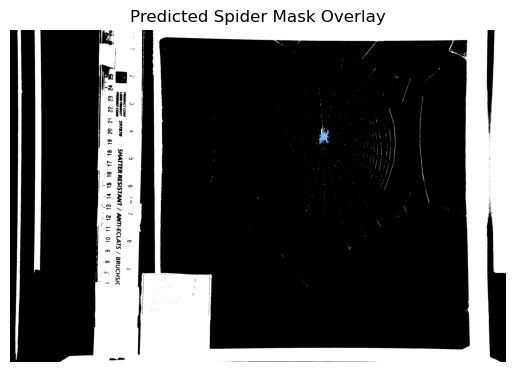

In [323]:
plt.imshow(ref_img_bgr)
plt.axis('off')
plt.title("Predicted Spider Mask Overlay")
show_mask(ref_mask, plt.gca())
plt.show()

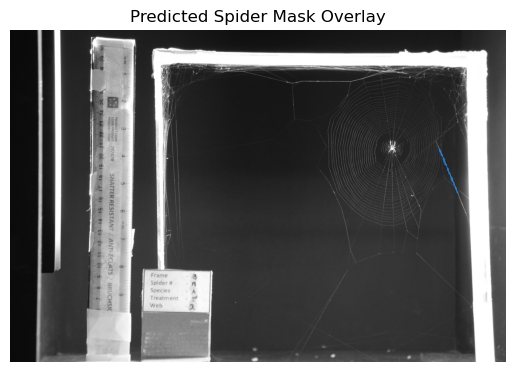

In [324]:
plt.imshow(new_img_bgr)
plt.axis('off')
plt.title("Predicted Spider Mask Overlay")
show_mask(pred_mask, plt.gca())
plt.show()

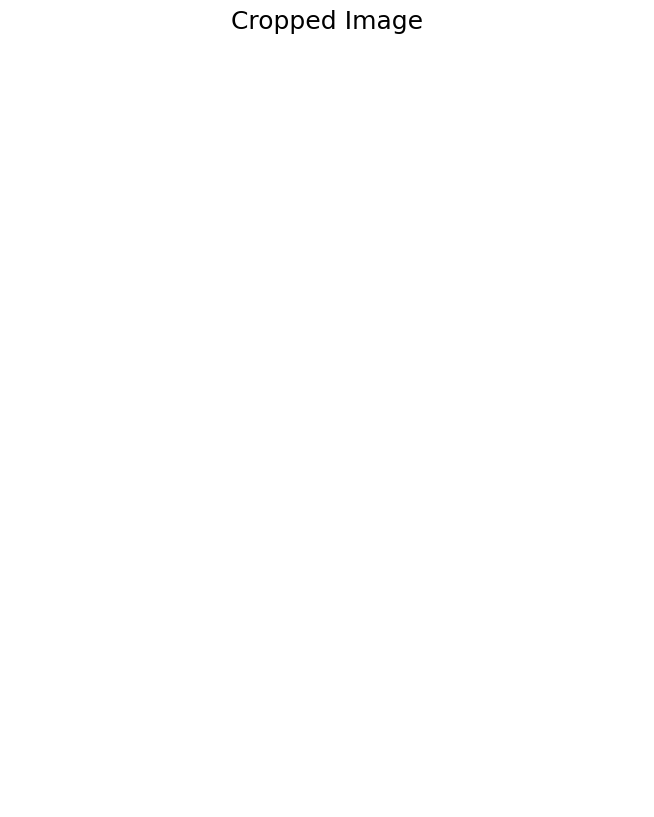

In [306]:
gray = cv2.cvtColor(new_img_bgr, cv2.COLOR_BGR2GRAY)
_, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
edit_bgr = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGR)

crop, cropMask = crop_to_mask_circle(edit_bgr, pred_mask)

plt.figure(figsize=(10,10))
plt.imshow(crop)
plt.title(f"Cropped Image", fontsize=18)
plt.axis('off')
plt.show()  

In [275]:
def process_spider(crop):
    if len(crop.shape) == 3:
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # Optional: Morphological closing to fill small holes in legs/body
    kernel = np.ones((3, 3), np.uint8)
    edited = cv2.morphologyEx(crop, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edited, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    edited = np.zeros_like(edited)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = float(w) / h if h != 0 else 0

        if area > 500 and aspect_ratio < 4:  # keep only “chunkier” shapes
            cv2.drawContours(edited, [cnt], -1, 255, thickness=cv2.FILLED)   
    # Smooth the binary spider mask before analysis
    edited = cv2.GaussianBlur(edited, (5, 5), 0)

    # Optional: Morphological closing to fill small holes in legs/body
    kernel = np.ones((3, 3), np.uint8)
    edited = cv2.morphologyEx(edited, cv2.MORPH_CLOSE, kernel)

    # Re-binarize after smoothing (ensures pixel values are 0 or 255 again)
    _, edited = cv2.threshold(edited, 127, 255, cv2.THRESH_BINARY) 
    return edited



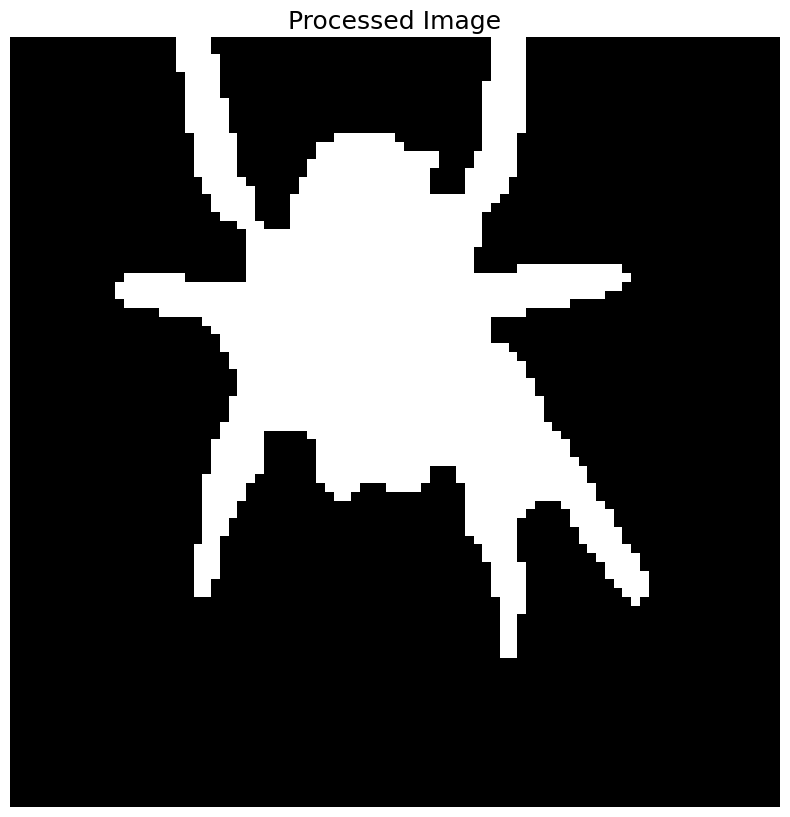

In [302]:
processed = process_spider(crop)

plt.figure(figsize=(10,10))
plt.imshow(processed, cmap = 'gray')
plt.title(f"Processed Image", fontsize=18)
plt.axis('off')
plt.show()  

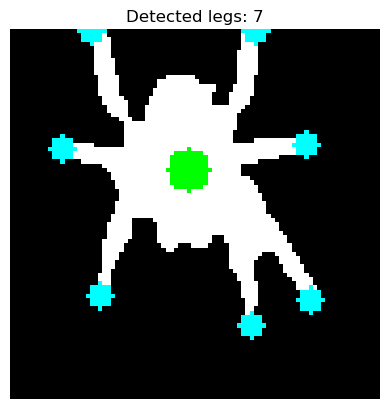

7


In [303]:
print(count_spider_legs(processed, True))

In [12]:
IMG_SIZE = 256

image_paths =  glob.glob("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//images/*.tif")
masks_paths = glob.glob("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train/mask/*.tiff")

allImages = []
allMasks = []
for imgFile, imgMask, in tqdm(zip(image_paths, masks_paths), total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  img = img/255.0
  allImages.append(img)

  mask = cv2.imread(imgMask, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
  mask[mask > 0] = 1
  allMasks.append(mask)



images = np.array(allImages)
masks = np.array(allMasks)
masks= masks.astype(np.uint8)
print(images.shape)
print(masks.shape)

100%|██████████| 216/216 [00:06<00:00, 31.12it/s]


(216, 256, 256, 3)
(216, 256, 256)


In [14]:
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

In [15]:
from datasets import Dataset
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


dataset

c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'label'],
    num_rows: 216
})

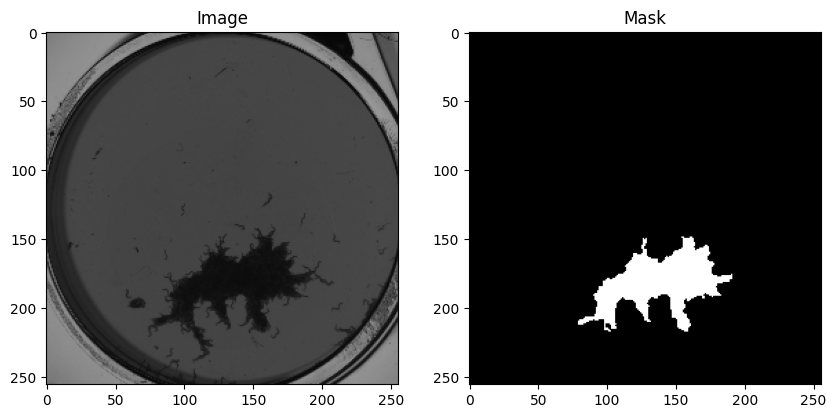

In [16]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")
# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Display the images side by side
plt.show()

In [68]:
example_image.shape()

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [17]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [18]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [19]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [21]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)


In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [23]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [24]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [26]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [42]:
! set CUDA_HOME=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
! set PATH=%CUDA_HOME%\bin;%CUDA_HOME%\libnvvp;%PATH%

In [9]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: []


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 938911069328143034
xla_global_id: -1
]


In [27]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/108 [00:00<?, ?it/s]c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 0
Mean loss: 0.28077647196887817


100%|██████████| 108/108 [06:03<00:00,  3.37s/it]


EPOCH: 1
Mean loss: 0.16294018187801595


100%|██████████| 108/108 [06:03<00:00,  3.37s/it]


EPOCH: 2
Mean loss: 0.14137398099733722


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 3
Mean loss: 0.13152219186088554


100%|██████████| 108/108 [06:05<00:00,  3.38s/it]


EPOCH: 4
Mean loss: 0.12232539617387508


100%|██████████| 108/108 [06:04<00:00,  3.37s/it]


EPOCH: 5
Mean loss: 0.11441676379008978


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 6
Mean loss: 0.10976665418733049


100%|██████████| 108/108 [06:05<00:00,  3.38s/it]


EPOCH: 7
Mean loss: 0.10433707543200364


100%|██████████| 108/108 [06:04<00:00,  3.37s/it]


EPOCH: 8
Mean loss: 0.10213419172429929


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]

EPOCH: 9
Mean loss: 0.09924268924320738


In [28]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//models/model_great_checkpoint.pth")

In [29]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//models/model_great_checkpoint.pth"))

<All keys matched successfully>

In [30]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


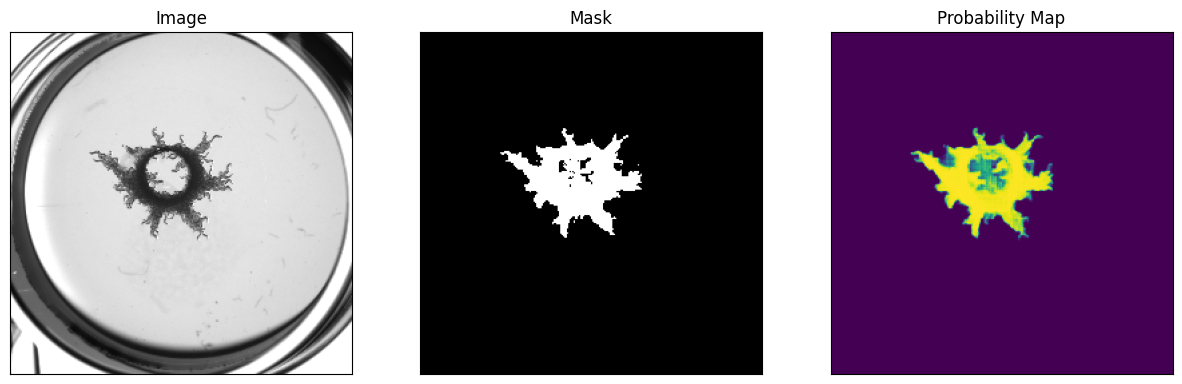

In [55]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
#test_image = test_image.convert("RGB")

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
plt.subplot(1, 3, 1)
plt.imshow(np.array(test_image), cmap='gray')
plt.title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
# Display the images side by side
plt.show()

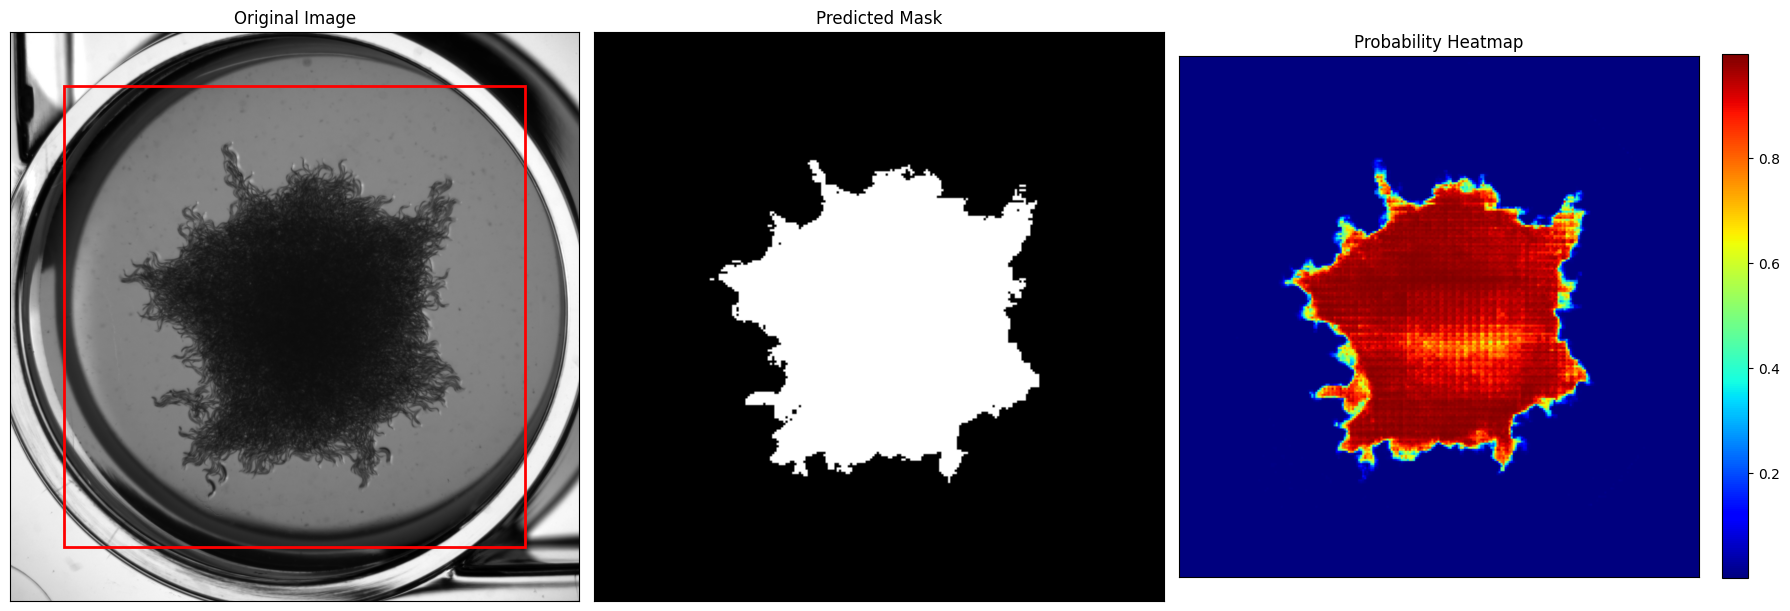

In [100]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path to your new image
image_path = "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/validation/images2/Test 6-22-24_Series001_t019_ch00.tif"

# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)

def auto_detect_prompt(gray_image, scale_factor=0.81):  # Reduce size depends on your image
    _, thresh = cv2.threshold(gray_image, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        
        # Compute center of the bounding box
        center_x, center_y = x + w // 2, y + h // 2

        # Reduce the bounding box size
        new_w, new_h = int(w * scale_factor), int(h * scale_factor)

        # Compute new top-left and bottom-right coordinates
        new_x1 = max(center_x - new_w // 2, 0)
        new_y1 = max(center_y - new_h // 2, 0)
        new_x2 = min(center_x + new_w // 2, gray_image.shape[1])
        new_y2 = min(center_y + new_h // 2, gray_image.shape[0])

        return [new_x1, new_y1, new_x2, new_y2]
    else:
        h, w = gray_image.shape
        return [w//4, h//4, 3*w//4, 3*h//4]  # Default case

# Get automatic prompt (modify this logic based on your needs)
prompt = auto_detect_prompt(original_grayscale)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[prompt]],       # Use detected bounding box
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with bounding box overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_grayscale, cmap='gray')
axes[0].set_title("Original Image")
axes[0].add_patch(plt.Rectangle((prompt[0], prompt[1]),
                              prompt[2]-prompt[0],
                              prompt[3]-prompt[1],
                              fill=False, edgecolor='red', linewidth=2))

# Predicted Mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Predicted Mask")

# Probability Map
prob_map = axes[2].imshow(medsam_seg_prob, cmap='jet')
plt.colorbar(prob_map, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title("Probability Heatmap")

# Formatting
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

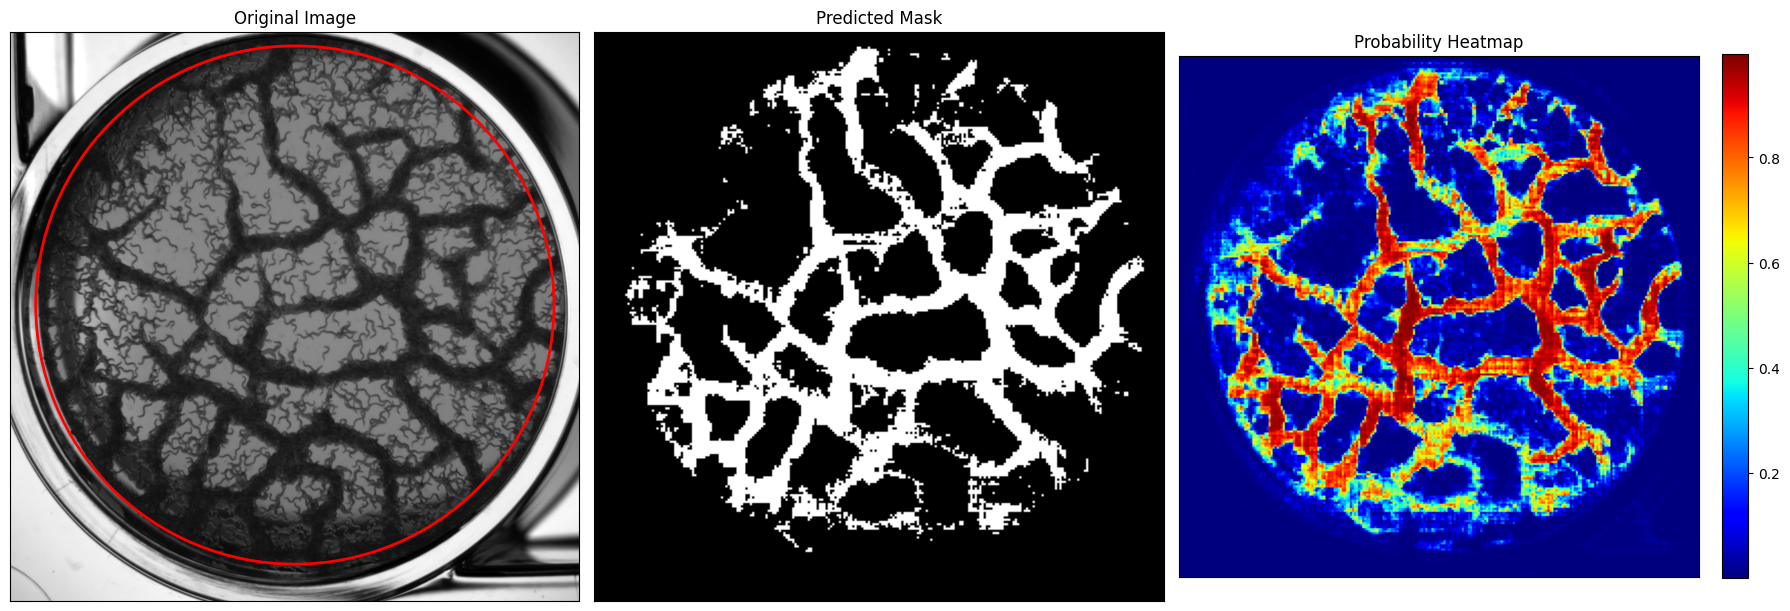

In [113]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Path to your new image
image_path = "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/validation/images2/Test 6-22-24_Series001_t322_ch00.tif"

# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)

# Function to detect a circular bounding region
def auto_detect_prompt(gray_image, scale_factor=0.98, x_offset=0, y_offset=0):  
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(c)  # Get enclosing circle
        
        # Apply manual shift
        return int(x) + x_offset, int(y) + y_offset, int(radius * scale_factor)
    else:
        # Default: center of image with estimated radius
        h, w = gray_image.shape
        return w // 2, h // 2, min(w, h) // 6  # Center with 1/4th image size

# Adjust these values to move the circle
x_shift = 120  # Move right (negative to move left)
y_shift = 100 # Move up (positive to move down)

# Get the adjusted circular prompt
cx, cy, r = auto_detect_prompt(original_grayscale, scale_factor=0.76, x_offset=x_shift, y_offset=y_shift)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[[cx - r, cy - r, cx + r, cy + r]]],  # Convert circle to bounding box format
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.45).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with circular bounding region
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_grayscale, cmap='gray')
axes[0].set_title("Original Image")

# Draw circle instead of rectangle
circle = plt.Circle((cx, cy), r, color='red', fill=False, linewidth=2)
axes[0].add_patch(circle)

# Predicted Mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Predicted Mask")

# Probability Map
prob_map = axes[2].imshow(medsam_seg_prob, cmap='jet')
plt.colorbar(prob_map, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title("Probability Heatmap")

# Formatting
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [60]:
import numpy as np

# Assuming medsam_seg_prob is your probability heatmap
# Define the probability range I am interested in
lower_prob = 0.5  # Example lower bound
upper_prob = 1.0  # Example upper bound

# Create a binary mask for the specified probability range
prob_mask = (medsam_seg_prob >= lower_prob) & (medsam_seg_prob <= upper_prob)

# Calculate the area by counting the pixels in the mask
area_pixels = np.sum(prob_mask)

# If you know the area each pixel represents (e.g., in square meters), you can calculate the total area
pixel_area = 1.0  # Replace with the actual area per pixel (e.g., in square meters)
total_area = area_pixels * pixel_area

print(f"Area of probability range [{lower_prob}, {upper_prob}]: {total_area} square units")

Area of probability range [0.5, 1.0]: 13653.0 square units


In [66]:
area_pixels.shape

()